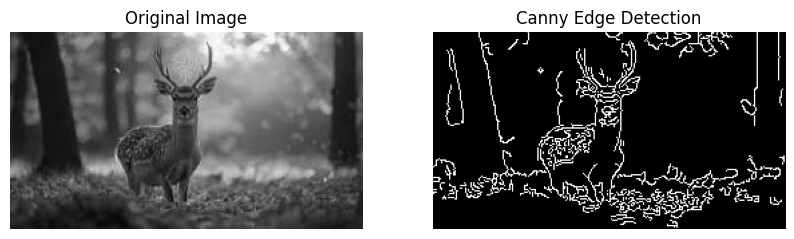

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'deer_image.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Canny Edge Detection
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(image, low_threshold, high_threshold)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.show()


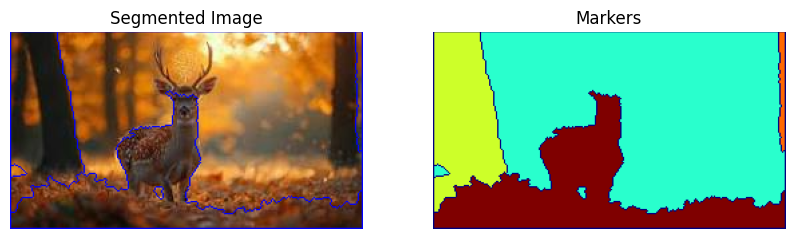

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'deer_image.jpeg'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers for watershed
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed algorithm
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(markers, cmap='jet')
plt.title('Markers')
plt.axis('off')

plt.show()


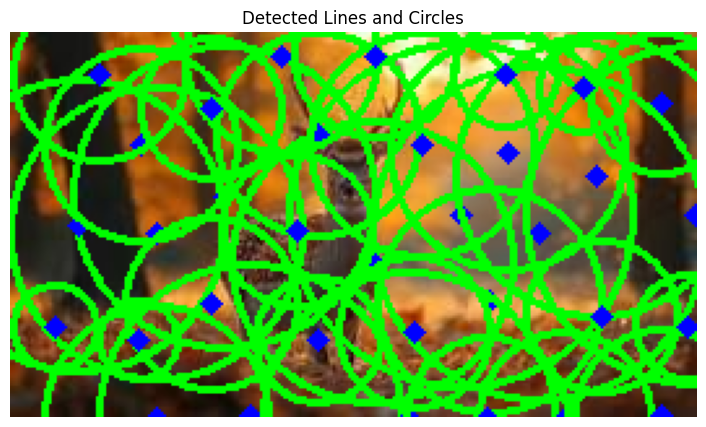

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'deer_image.jpeg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# edge detection using Canny
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough Transform for Line Detection
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Hough Transform for Circle Detection
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=10, maxRadius=100)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(image, (i[0], i[1]), 2, (255, 0, 0), 3)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines and Circles')
plt.axis('off')
plt.show()


In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


--2025-02-24 08:34:24--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  25.7MB/s    in 9.7s    

2025-02-24 08:36:22 (24.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2025-02-24 08:36:23--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [9]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2025-02-24 08:37:15--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2025-02-24 08:37:15 (27.1 MB/s) - ‘coco.names’ saved [625/625]



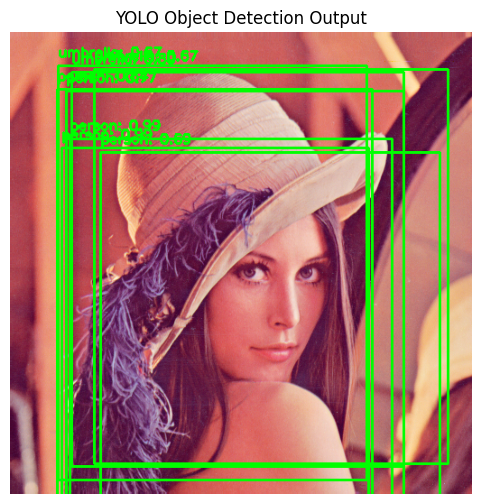

In [12]:
import os
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'Lena_Image.png'
image = cv2.imread(image_path)

def yolo_object_detection(image_path):
    weights_path = "yolov3.weights"
    config_path = "yolov3.cfg"

    net = cv2.dnn.readNet(weights_path, config_path)

    with open("coco.names", "r") as f:
        class_names = [line.strip() for line in f.readlines()]

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found! Check the file path.")
        return

    height, width = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                color = (0, 255, 0)
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                label = f"{class_names[class_id]}: {confidence:.2f}"
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("YOLO Object Detection Output")
    plt.show()

yolo_object_detection('Lena_Image.png')

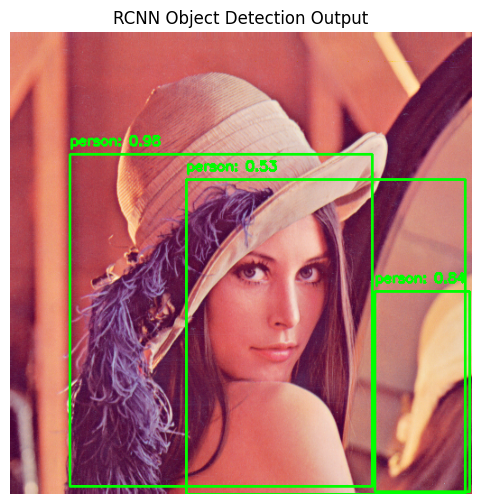

In [14]:
import torch
import torchvision.transforms as transforms
import torchvision.models.detection as models
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

model = models.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

def rcnn_object_detection(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        predictions = model(image_tensor)

    image_cv = cv2.imread(image_path)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    boxes = predictions[0]["boxes"].cpu().numpy()
    scores = predictions[0]["scores"].cpu().numpy()
    labels = predictions[0]["labels"].cpu().numpy()

    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
        'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
        'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'
    ]

    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        if score > confidence_threshold:
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label_text = f"{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}"
            cv2.putText(image_cv, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_cv)
    plt.axis("off")
    plt.title("RCNN Object Detection Output")
    plt.show()
rcnn_object_detection('Lena_Image.png')